# Q7: Modeling

**Phase 8:** Modeling  
**Points: 9 points**

**Focus:** Train multiple models, evaluate performance, compare models, extract feature importance.

**Lecture Reference:** Lecture 11, Notebook 4 ([`11/demo/04_modeling_results.ipynb`](https://github.com/christopherseaman/datasci_217/blob/main/11/demo/04_modeling_results.ipynb)), Phase 8. Also see Lecture 10 (modeling with sklearn and XGBoost).

---

## Setup

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import os

# Load prepared data from Q6
X_train = pd.read_csv('output/q6_X_train.csv')
X_test = pd.read_csv('output/q6_X_test.csv')
y_train = pd.read_csv('output/q6_y_train.csv').squeeze()  # Convert to Series
y_test = pd.read_csv('output/q6_y_test.csv').squeeze()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

missing_values_count_X_train = X_train.isnull().sum()
print("Missing values per column X:\n", missing_values_count_X_train)

missing_values_count_y_train = y_train.isnull().sum()
print("Missing values per column y:\n", missing_values_count_y_train)



Training set: (155176, 4)
Test set: (38795, 4)
Missing values per column X:
 Humidity                0
Wet Bulb Temperature    0
Wind Speed              0
Solar Radiation         0
dtype: int64
Missing values per column y:
 0


---

## Objective

Train multiple models, evaluate performance, compare models, and extract feature importance.

---

## ⚠️ Data Leakage Warning

If you see suspiciously perfect model performance, this likely indicates data leakage. Common warning signs:

**Warning Metrics:**
- **Perfect R² = 1.0000** (or very close, like 0.9999+)
- **Zero or near-zero RMSE/MAE** (e.g., RMSE < 0.01°C for temperature prediction)
- **Train and test performance nearly identical** (difference < 0.01)
- **Unrealistic precision**: Errors smaller than measurement precision (e.g., < 0.1°C for temperature sensors)
- **Feature correlation > 0.99** with target (check correlations between features and target)

**Common Causes:**
- **Circular prediction logic**: Using rolling windows of the target variable to predict itself
  - Example: Using `air_temp_rolling_7h` to predict `Air Temperature`
  - This is like predicting temperature from smoothed temperature - circular reasoning!
- **Features nearly identical to target**: Any feature with correlation > 0.99 with the target
- **Including target variable directly**: Accidentally including the target in features

**How to Check:**
- Calculate correlations between each feature and the target
- If any feature has correlation > 0.95, investigate whether it's legitimate or leakage
- For time series: Be especially careful with rolling windows, lag features, or any transformation of the target variable

**Example of Problematic Feature:**
- `air_temp_rolling_7h` (7-hour rolling mean of Air Temperature) when predicting Air Temperature
- This feature has ~99.4% correlation with the target - too high to be useful and indicates circular logic

**Solution:**
- Only create rolling windows for **predictor variables**, not the target
- Use rolling windows of: Wind Speed, Humidity, Barometric Pressure, etc.
- Avoid rolling windows of: Air Temperature (if that's your target)

---

## Required Artifacts

You must create exactly these 3 files in the `output/` directory:

### 1. `output/q7_predictions.csv`
**Format:** CSV file
**Required Columns (exact names):**
- `actual` - Actual target values from test set
- `predicted_linear` or `predicted_model1` - Predictions from first model (e.g., Linear Regression)
- `predicted_xgboost` or `predicted_model2` - Predictions from second model (e.g., XGBoost)
- Additional columns for additional models (e.g., `predicted_random_forest` or `predicted_model3`)

**Requirements:**
- Must have at least 2 model prediction columns (in addition to `actual`)
- All values must be numeric (float)
- Same number of rows as test set
- **No index column** (save with `index=False`)

**Example:**
```csv
actual,predicted_linear,predicted_xgboost
15.2,14.8,15.1
15.3,15.0,15.2
...
```

### 2. `output/q7_model_metrics.txt`
**Format:** Plain text file
**Content:** Performance metrics for each model
**Required information for each model:**
- Model name
- At least R² score for both train and test sets (additional metrics like RMSE, MAE recommended but optional)

**Requirements:**
- Clearly labeled (model name, metric name)
- **At minimum:** R² (or R-squared or R^2) for train and test for each model
- Additional metrics (RMSE, MAE) are recommended for a complete analysis
- Format should be readable

**Example format (minimum - R² only):**
```
MODEL PERFORMANCE METRICS
========================

LINEAR REGRESSION:
  Train R²: 0.3048
  Test R²:  0.3046

XGBOOST:
  Train R²: 0.9091
  Test R²:  0.7684
```

**Example format (recommended - with additional metrics):**
```
MODEL PERFORMANCE METRICS
========================

LINEAR REGRESSION:
  Train R²: 0.3048
  Test R²:  0.3046
  Train RMSE: 8.42
  Test RMSE:  8.43
  Train MAE:  7.03
  Test MAE:   7.04

XGBOOST:
  Train R²: 0.9091
  Test R²:  0.7684
  Train RMSE: 3.45
  Test RMSE:  4.87
  Train MAE:  2.58
  Test MAE:   3.66
```

### 3. `output/q7_feature_importance.csv`
**Format:** CSV file
**Required Columns (exact names):** `feature`, `importance`
**Content:** Feature importance from tree-based models (XGBoost, Random Forest)
**Requirements:**
- One row per feature
- `feature`: Feature name (string)
- `importance`: Importance score (float, typically 0-1, sum to 1)
- Sorted by importance (descending)
- **No index column** (save with `index=False`)

**Note:** Tree-based models (XGBoost, Random Forest) provide feature importance directly via `.feature_importances_`. If using only Linear Regression, you can use the absolute values of coefficients as a proxy for importance.

**Example:**
```csv
feature,importance
Air Temperature,0.6539
hour,0.1234
month,0.0892
Water Temperature,0.0456
...
```

---

## Requirements Checklist

- [ ] At least 2 different models trained
  - **Suggested:** Linear Regression and XGBoost (or Random Forest)
  - You may choose other models if appropriate
- [ ] Performance evaluated on both train and test sets
- [ ] Models compared
- [ ] Feature importance extracted
  - Tree-based models: use `.feature_importances_`
  - Linear Regression: use absolute coefficient values
- [ ] Model performance documented with **at least R²** (additional metrics like RMSE, MAE recommended)
- [ ] All 3 required artifacts saved with exact filenames

---

## Your Approach

1. **Check for data leakage** - Before training, compute correlations between features and target. Any feature with correlation > 0.95 should be investigated and considered for removal.
2. **Train at least 2 models** - Fit models to training data, generate predictions for both train and test sets
3. **Calculate metrics** - At minimum R² for train and test; RMSE and MAE recommended
4. **Extract feature importance** - Use `.feature_importances_` for tree-based models, or coefficient magnitudes for linear models
5. **Save predictions** - DataFrame with `actual` column plus `predicted_*` columns for each model
6. **Save metrics** - Write clearly labeled metrics to text file

---

## Decision Points

- **Model selection:** Train at least 2 different models. We suggest starting with **Linear Regression** and **XGBoost** - these work well and demonstrate different modeling approaches (linear vs gradient boosting). You may choose other models if appropriate (e.g., Random Forest, Gradient Boosting, etc.). See Lecture 11 Notebook 4 for examples.
- **Evaluation metrics:** Report at least one metric for each model. We suggest **R² score** (coefficient of determination) - it works for both Linear Regression and XGBoost, and all regression models. It measures the proportion of variance explained and is easy to interpret. Alternative metrics that work well for both models include **RMSE** (Root Mean Squared Error) or **MAE** (Mean Absolute Error). You may include additional metrics if relevant (e.g., MAPE, adjusted R²). Compare train vs test performance to check for overfitting.
- **Feature importance:** If using tree-based models (like XGBoost), extract feature importance to understand which features matter most.

---

## Interpreting Model Performance

**Warning Signs of Data Leakage:**
- R² = 1.0000 (perfect score) or R² > 0.999
- RMSE or MAE = 0.0 or unrealistically small (< 0.01 for temperature)
- Train and test performance nearly identical (difference < 0.01)
- Any feature with correlation > 0.99 with target

**Realistic Expectations:**
- For temperature prediction: RMSE of 0.5-2.0°C is realistic
- R² of 0.85-0.98 is strong but realistic
- Some difference between train and test performance is normal

**If you see warning signs:**
1. Check your features for data leakage (see Data Leakage Warning above)
2. Calculate correlations between features and target
3. Remove features that are transformations of the target variable
4. Re-train models and verify performance is now realistic

---

## Checkpoint

After Q7, you should have:
- [ ] At least 2 models trained (suggested: Linear Regression and XGBoost)
- [ ] Performance metrics calculated (at minimum: one metric like R², RMSE, or MAE for train and test; additional metrics recommended)
- [ ] Models compared
- [ ] Feature importance extracted (if applicable - tree-based models like XGBoost)
- [ ] All 3 artifacts saved: `q7_predictions.csv`, `q7_model_metrics.txt`, `q7_feature_importance.csv`

---

**Next:** Continue to `q8_results.md` for Results.


In [5]:
import os

# Model evaluation helper functions
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    """
    Calculate standard regression metrics.

    Demonstrates DRY principle: evaluation logic in one place.

    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    dataset_name : str
        Name for display purposes

    Returns:
    --------
    dict : Dictionary containing RMSE, MAE, and R² scores
    """
    return {
        'dataset': dataset_name,
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

def assess_overfitting(train_r2, test_r2):
    """
    Assess model overfitting by comparing train and test R² scores.

    Overfitting gap = Train R² - Test R²
    - < 5%: Excellent generalization
    - 5-10%: Good generalization
    - 10-20%: Some overfitting - consider regularization
    - > 20%: Severe overfitting - model needs adjustment

    Parameters:
    -----------
    train_r2 : float
        R² score on training set
    test_r2 : float
        R² score on test set

    Returns:
    --------
    tuple : (gap, status_message)
    """
    gap = train_r2 - test_r2

    if gap < 0.05:
        return gap, "✅ Excellent generalization"
    elif gap < 0.10:
        return gap, "✅ Good generalization"
    elif gap < 0.20:
        return gap, "⚠️ Some overfitting - consider regularization"
    else:
        return gap, "❌ Severe overfitting - model needs adjustment"

# Model hyperparameters
RANDOM_SEED = 42  # For reproducible results

# Random Forest hyperparameters
RF_N_ESTIMATORS = 100  # Number of trees (more = better but slower)
RF_MAX_DEPTH = 10      # Max tree depth (lower = less overfitting)

# XGBoost hyperparameters
XGB_N_ESTIMATORS = 100    # Number of boosting rounds
XGB_MAX_DEPTH = 6         # Max tree depth (XGBoost default, shallower than RF)
XGB_LEARNING_RATE = 0.1   # Step size shrinkage (lower = more conservative)

In [6]:
X_train.select_dtypes(exclude=[np.number]).columns.tolist()

[]

In [7]:
import os

# Train linear regression model
display("#Model 1: Linear Regression")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate using helper function
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Training")
test_metrics_lr = evaluate_model(y_test, y_test_pred_lr, "Test")

# Check for overfitting using helper function
overfit_lr, overfit_status = assess_overfitting(train_metrics_lr['r2'], test_metrics_lr['r2'])

display("### Performance Results")
display(pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Training': [
        f"{train_metrics_lr['rmse']:.2f}",
        f"{train_metrics_lr['mae']:.2f}",
        f"{train_metrics_lr['r2']:.4f}"
    ],
    'Test': [
        f"{test_metrics_lr['rmse']:.2f}",
        f"{test_metrics_lr['mae']:.2f}",
        f"{test_metrics_lr['r2']:.4f}"
    ]
}))
display(f"**Overfitting (R² difference):** {overfit_lr:.4f} — {overfit_status}")

# Store for comparison later
train_rmse_lr, test_rmse_lr = train_metrics_lr['rmse'], test_metrics_lr['rmse']
train_r2_lr, test_r2_lr = train_metrics_lr['r2'], test_metrics_lr['r2']

'#Model 1: Linear Regression'

'### Performance Results'

,Metric,Training,Test
0,RMSE,6.04,3.26
1,MAE,3.48,2.15
2,R²,0.6625,0.8940


'**Overfitting (R² difference):** -0.2316 — ✅ Excellent generalization'

In [19]:
import os 

# Train XGBoost model
display("# Model 3: XGBoost")

xgb_model = xgb.XGBRegressor(
    n_estimators=XGB_N_ESTIMATORS,
    max_depth=XGB_MAX_DEPTH,
    learning_rate=XGB_LEARNING_RATE,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate using helper function
train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Training")
test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")

# Check for overfitting using helper function
overfit_xgb, overfit_status = assess_overfitting(train_metrics_xgb['r2'], test_metrics_xgb['r2'])

display("### Performance Results")
display(pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Training': [
        f"{train_metrics_xgb['rmse']:.2f}",
        f"{train_metrics_xgb['mae']:.2f}",
        f"{train_metrics_xgb['r2']:.4f}"
    ],
    'Test': [
        f"{test_metrics_xgb['rmse']:.2f}",
        f"{test_metrics_xgb['mae']:.2f}",
        f"{test_metrics_xgb['r2']:.4f}"
    ]
}))
display(f"**Overfitting (R² difference):** {overfit_xgb:.4f} — {overfit_status}")

# Store for comparison later
train_rmse_xgb, test_rmse_xgb = train_metrics_xgb['rmse'], test_metrics_xgb['rmse']
train_r2_xgb, test_r2_xgb = train_metrics_xgb['r2'], test_metrics_xgb['r2']

'# Model 3: XGBoost'

'### Performance Results'

,Metric,Training,Test
0,RMSE,4.77,2.91
1,MAE,2.39,1.43
2,R²,0.7894,0.9154


'**Overfitting (R² difference):** -0.1260 — ✅ Excellent generalization'

In [21]:
import os

# Extract feature importance from the trained model
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

display("### Top 3 Most Important Features")
display(xgb_importance.head(3))

xgb_importance.to_csv('output/q7_feature_importance.csv', index = False)

'### Top 3 Most Important Features'

,feature,importance
1,Wet Bulb Temperature,0.809471
3,Solar Radiation,0.086077
2,Wind Speed,0.055339


In [30]:
# Compare all models
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'Train RMSE': [train_rmse_lr, train_rmse_xgb],
    'Test RMSE': [test_rmse_lr, test_rmse_xgb],
    'Train R²': [train_r2_lr, train_r2_xgb],
    'Test R²': [test_r2_lr, test_r2_xgb],
    'Overfitting': [overfit_lr, overfit_xgb]
})

comparison = comparison.round(4)
comparison['RMSE_diff'] = comparison['Train RMSE'] - comparison['Test RMSE']

display("# Model Comparison")
display(comparison)

#Model Performance metrics

with open("output/q7_model_metrics.txt", "w") as f:
    f.write("MODEL PERFORMANCE METRICS \n========================= \n\n")
    f.write(f"LINEAR REGRESSION: \n")
    f.write(f"  - Train R²: {train_r2_lr:.2f}  \n")
    f.write(f"  - Test R²: {test_r2_lr:.2f} \n")
    f.write(f"  - Train RMSE: {train_rmse_lr:.2f} \n")
    f.write(f"  - Test RMSE: {test_rmse_lr:.2f} \n\n")
    f.write(f"XGBOOST: \n")
    f.write(f"  - Train R²: {train_r2_xgb:.2f}  \n")
    f.write(f"  - Test R²: {test_r2_xgb:.2f} \n")
    f.write(f"  - Train RMSE: {train_rmse_xgb:.2f} \n")
    f.write(f"  - Test RMSE: {test_rmse_xgb:.2f} \n\n")


'# Model Comparison'

,Model,Train RMSE,Test RMSE,Train R²,Test R²,Overfitting,RMSE_diff
0,Linear Regression,6.0416,3.2589,0.6625,0.8940,-0.2316,2.7827
1,XGBoost,4.7717,2.9111,0.7894,0.9154,-0.1260,1.8606


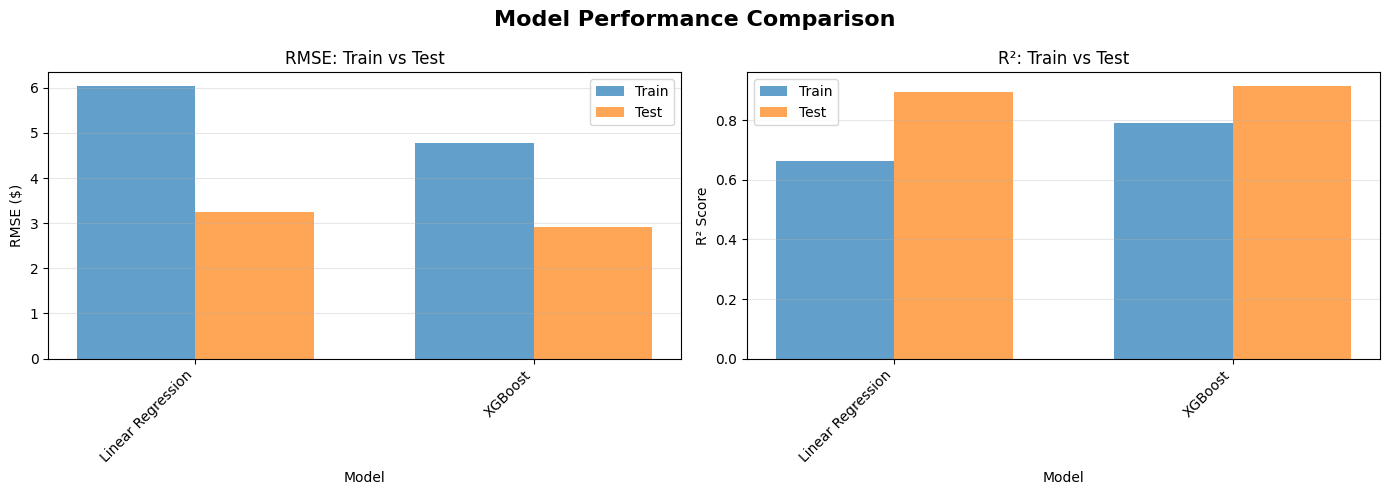

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
x_pos = np.arange(len(comparison))
width = 0.35
axes[0].bar(x_pos - width/2, comparison['Train RMSE'], width, label='Train', alpha=0.7)
axes[0].bar(x_pos + width/2, comparison['Test RMSE'], width, label='Test', alpha=0.7)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE: Train vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(x_pos - width/2, comparison['Train R²'], width, label='Train', alpha=0.7)
axes[1].bar(x_pos + width/2, comparison['Test R²'], width, label='Test', alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R²: Train vs Test')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [22]:
# Select best model (lowest test RMSE)
best_model_idx = comparison['Test RMSE'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Model']

display(f"""
### Best Model: **{best_model_name}**

- **Test RMSE:** {comparison.loc[best_model_idx, 'Test RMSE']:.2f} 
- **Test R²:** {comparison.loc[best_model_idx, 'Test R²']:.4f}
""")

'\n### Best Model: **XGBoost**\n\n- **Test RMSE:** 2.91 \n- **Test R²:** 0.9154\n'

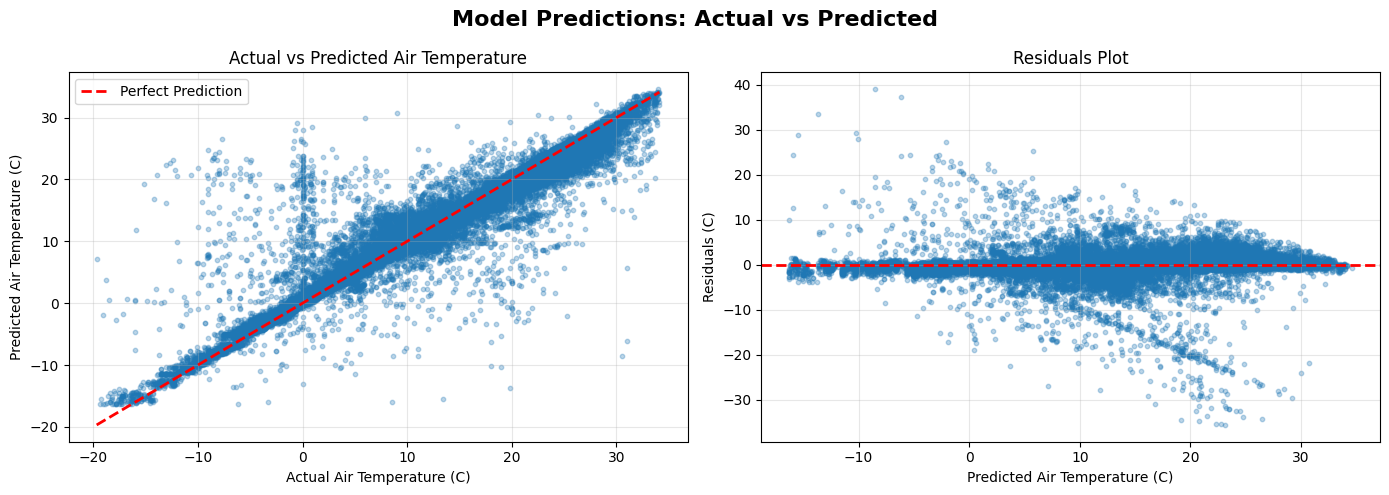

'### Residuals Statistics'

,Statistic,Value
0,Mean,0.17
1,Std,2.91
2,Min,-35.54
3,Max,39.05


In [18]:
y_test_pred_best = y_test_pred_xgb

# Scatter plot: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Predictions: Actual vs Predicted', fontsize=16, fontweight='bold')

# Scatter plot
axes[0].scatter(y_test, y_test_pred_best, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Air Temperature (C)')
axes[0].set_ylabel('Predicted Air Temperature (C)')
axes[0].set_title('Actual vs Predicted Air Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Air Temperature (C)')
axes[1].set_ylabel('Residuals (C)')
axes[1].set_title('Residuals Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals statistics
display("### Residuals Statistics")
display(pd.DataFrame({
    'Statistic': ['Mean', 'Std', 'Min', 'Max'],
    'Value': [
        f"{residuals.mean():.2f}",
        f"{residuals.std():.2f}",
        f"{residuals.min():.2f}",
        f"{residuals.max():.2f}"
    ]
}))

In [ ]:
import os

df_preds = pd.DataFrame({
    "actual": y_test.values,                  # actual target values
    "predicted_linear": y_test_pred_lr,       # model 1 predictions
    "predicted_xgboost": y_test_pred_xgb      # model 2 predictions
})

df_preds = df_preds.round(1)

df_preds.to_csv('output/q7_predictions.csv', index = False)

